# <p style="text-align:center" color="red"><span style="color:red">Projet d'Apprentissage Automatique avec `Deep Learning`</span></p>
## <p style="text-align:center" color="red"><span style="color:green">Apprentissage `Semi-Supervisé` sur `MNIST digits`</span></p>

**Membres du Groupe :**

- Meryem Belkaid - `AMSD`
- Hafsa Boanani - `AMSD`
- Abir Oumghar - `AMSD`

### Importation des bibliothèques nécessaires à notre projet

In [1]:
# Ignore warnings in Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

# Imports related to TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Imports related to data manipulation with scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle

# Classification evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss

# Import related to image processing with OpenCV
import cv2

# Imports related to visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import related to numerical operations with NumPy
import numpy as np

# Other libraries
import time

### Charger le jeu de données MNIST digits

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
<b><code>MNIST digits</code></b> est un ensemble de données qui comprend des images de chiffres manuscrits largement utilisé dans le domaine de l'apprentissage automatique. Il sert souvent de banc d'essai pour évaluer les performances des algorithmes de classification d'images. — <code>Wikipedia</code></b>

[Plus d'informations..](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST)
</div>

In [2]:
# Charger le jeu de données MNIST
(x_train_complet, y_train_complet), (x_test, y_test) = mnist.load_data()

# Affichage du nombre d'échantillons dans le jeu d'entraînement et de test
print(f"Nombre d'échantillons dans l'ensemble d'entraînement : {len(x_train_complet)}")
print(f"Nombre d'échantillons dans l'ensemble de test : {len(x_test)}")

Nombre d'échantillons dans l'ensemble d'entraînement : 60000
Nombre d'échantillons dans l'ensemble de test : 10000


#### Exploration des données ( Visualisation de 10 échantillons aléatoires )

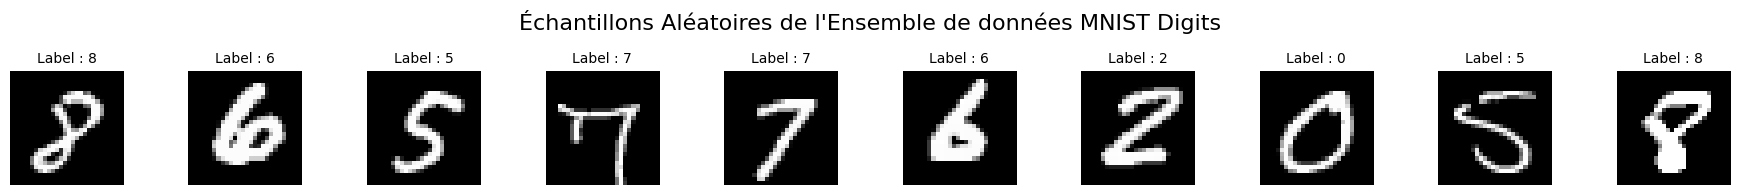

In [3]:
# Générer des indices aléatoires
indices_aleatoires = np.random.choice(len(x_train_complet), 10, replace=False)

# Créer le graphique avec une seule rangée et 10 colonnes
fig, axs = plt.subplots(1, 10, figsize=(18, 2))
fig.suptitle('Échantillons Aléatoires de l\'Ensemble de données MNIST Digits', fontsize=16)

for i, index in enumerate(indices_aleatoires):
    # Afficher l'étiquette
    label = y_train_complet[index]
    axs[i].set_title(f"Label : {label}", fontsize=10)
    
    # Remodeler l'image et l'afficher
    img = x_train_complet[index].reshape(28, 28)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')  # Désactiver l'axe pour une meilleure présentation

# Ajuster la disposition pour éviter la superposition
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Afficher le graphique
plt.show()

### Préparation des Données pour l'Entraînement `Semi-Supervisé`

In [4]:
# Paramètres pour la sélection des données
count_etiquetees_par_classe = 10
count_validation = 100
count_non_etiquetees_test = 59800

# Sélectionner un petit sous-ensemble pour les données étiquetées
etiquetees_indices = np.concatenate([np.random.choice(np.where(y_train_complet == classe)[0], size=count_etiquetees_par_classe, replace=False) for classe in np.unique(y_train_complet)])
x_etiquetees, y_etiquetees = x_train_complet[etiquetees_indices], y_train_complet[etiquetees_indices]

# Utiliser le reste des données comme non étiquetées
x_non_etiquetees, y_non_etiquetees = np.delete(x_train_complet, etiquetees_indices, axis=0), np.delete(y_train_complet, etiquetees_indices, axis=0)

# Utiliser StratifiedShuffleSplit pour diviser les données restantes en ensembles d'entraînement et de validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=count_validation, random_state=42)
for train_index, validation_index in sss.split(x_non_etiquetees, y_non_etiquetees):
    x_validation, y_validation = x_non_etiquetees[validation_index], y_non_etiquetees[validation_index]
    x_non_etiquetees, y_non_etiquetees = x_non_etiquetees[train_index], y_non_etiquetees[train_index]

# Prendre les échantillons restants comme non étiquetés pour le test
x_non_etiquetees_test, y_non_etiquetees_test = x_non_etiquetees[:count_non_etiquetees_test], y_non_etiquetees[:count_non_etiquetees_test]

# Mélanger les ensembles de données de la même manière
shuffle_indices = np.random.permutation(len(x_etiquetees))
x_etiquetees, y_etiquetees = x_etiquetees[shuffle_indices], y_etiquetees[shuffle_indices]

shuffle_indices = np.random.permutation(len(x_validation))
x_validation, y_validation = x_validation[shuffle_indices], y_validation[shuffle_indices]

shuffle_indices = np.random.permutation(len(x_non_etiquetees))
x_non_etiquetees, y_non_etiquetees_test = x_non_etiquetees[shuffle_indices], y_non_etiquetees_test[shuffle_indices]

# Afficher des informations sur les ensembles étiquetés, non étiquetés et de validation
print(f"Nombre d'échantillons étiquetés dans l'ensemble d'entraînement : {len(x_etiquetees)}")
print(f"\nNombre de classes uniques dans les données étiquetées : {len(np.unique(y_etiquetees))}")
print(f"Nombre d'échantillons non étiquetés dans l'ensemble de test : {len(x_non_etiquetees)}")
print(f"\nNombre d'échantillons dans l'ensemble de validation : {len(x_validation)}")
print(f"Nombre de classes uniques dans l'ensemble de validation : {len(np.unique(y_validation))}")

Nombre d'échantillons étiquetés dans l'ensemble d'entraînement : 100

Nombre de classes uniques dans les données étiquetées : 10
Nombre d'échantillons non étiquetés dans l'ensemble de test : 59800

Nombre d'échantillons dans l'ensemble de validation : 100
Nombre de classes uniques dans l'ensemble de validation : 10


> Jusqu'à présent, nous avons soigneusement sélectionné 100 images étiquetées équilibrées pour l'entraînement et 100 pour la validation, en respectant l'équilibre des données. Nous avons utilisé la méthode `Stratified Shuffle Split` de Scikit-learn pour assurer cet équilibre. Les 59,800 images restantes seront utilisées dans le cadre de l'apprentissage semi-supervisé.

### Prétraitement & Normalisation des Données

In [5]:
# Normaliser les valeurs des pixels des images d'entrée dans la plage [0, 1]
x_etiquetees, x_non_etiquetees, x_validation, x_test = x_etiquetees / 255.0, x_non_etiquetees / 255.0, x_validation / 255.0, x_test / 255.0

# Redimensionner les données en une seule dimension (pour les images)
taille_pixels = 28 * 28  # La taille des images MNIST est de 28x28 pixels
x_etiquetees = x_etiquetees.reshape(x_etiquetees.shape[0], taille_pixels)
x_non_etiquetees = x_non_etiquetees.reshape(x_non_etiquetees.shape[0], taille_pixels)
x_validation = x_validation.reshape(x_validation.shape[0], taille_pixels)
x_test = x_test.reshape(x_test.shape[0], taille_pixels)

# Afficher des informations sur les ensembles après prétraitement
print("Ensembles après prétraitement :")
print(f"Taille de l'ensemble étiqueté : {x_etiquetees.shape}")
print(f"Taille de l'ensemble non étiqueté : {x_non_etiquetees.shape}")
print(f"Taille de l'ensemble de validation : {x_validation.shape}")
print(f"Taille de l'ensemble de test : {x_test.shape}")

Ensembles après prétraitement :
Taille de l'ensemble étiqueté : (100, 784)
Taille de l'ensemble non étiqueté : (59800, 784)
Taille de l'ensemble de validation : (100, 784)
Taille de l'ensemble de test : (10000, 784)


> La normalisation des données MNIST est réalisée pour accélérer la convergence de l'entraînement, assurer la stabilité numérique et garantir une comparaison équitable entre les caractéristiques. Elle prévient également le surajustement en régularisant les poids du modèle.

In [6]:
# Mélanger les données pour éviter que l'ordre ait un impact sur l'entraînement
tf.random.set_seed(42)
x_etiquetees, y_etiquetees = shuffle(x_etiquetees, y_etiquetees)

> Mélanger les données MNIST avant l'entraînement prévient les biais liés à l'ordre des données, favorise une convergence plus rapide du modèle, et améliore sa capacité à généraliser à de nouvelles données.

## <p style="color:red;"><span style="color:black;">Modèle 1️⃣ : Modèle de Réseau de Neurones (NN) sur 100 Échantillons</span></p>

> - Dans un premier temps, comme mentionné dans l'article, nous allons utiliser le modèle proposé, le modèle NN, qui est un modèle simple. Nous allons d'abord l'utiliser dans un cadre supervisé et évaluer ses performances.

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
<b><code>Modèle de Réseau de Neurones (NN)</code></b> est une architecture de réseau neuronal artificiel récurrent (RNN) utilisée dans le domaine de l'apprentissage profond. Contrairement aux réseaux neuronaux standard à propagation avant, le LSTM possède des connexions de rétroaction. Il peut traiter non seulement des points de données individuels (comme des images), mais aussi des séquences entières de données (telles que la parole ou la vidéo). — <code>Wikipedia</code></b>

[Plus d'informations..](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents)
</div>


#### Création du modèle de réseau de neurones

In [7]:
modele_reseau_neurones = Sequential()
# Ajout d'une couche cachée avec 5000 neurones et une fonction d'activation ReLU
modele_reseau_neurones.add(Dense(5000, input_dim=784, activation='relu'))
# Ajout de la couche de sortie avec 10 neurones et une fonction d'activation sigmoïde
modele_reseau_neurones.add(Dense(10, activation='sigmoid'))
# Affichage du résumé du modèle
modele_reseau_neurones.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5000)              3925000   
                                                                 
 dense_1 (Dense)             (None, 10)                50010     
                                                                 
Total params: 3975010 (15.16 MB)
Trainable params: 3975010 (15.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Configuration du Modèle

In [8]:
# Compiler le modèle avec l'optimiseur Adam, la fonction de perte 'sparse_categorical_crossentropy' et la métrique de précision
modele_reseau_neurones.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage de la configuration du modèle
print("   Configuration du Modèle :")
print(f"   Optimiseur : Adam")
print(f"   Fonction de Perte : 'sparse_categorical_crossentropy'")
print(f"   Métriques : ['accuracy']")

   Configuration du Modèle :
   Optimiseur : Adam
   Fonction de Perte : 'sparse_categorical_crossentropy'
   Métriques : ['accuracy']


<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
<b><code>L'utilisation de `sparse_categorical_crossentropy` dans l'entraînement du modèle MNIST Digts</code></b> : cette approche est motivée par la nature des étiquettes associées aux images du jeu de données. MNIST attribue des entiers aux chiffres de 0 à 9 sans nécessiter une encodage one-hot explicite. La fonction de perte 'sparse_categorical_crossentropy' est donc appropriée pour ce scénario.

[En savoir plus sur 'sparse_categorical_crossentropy'](https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function:~:text=%5Bsource%5D-,SparseCategoricalCrossentropy%20class,-tf.keras)
</div>

#### Apprentissage du Modèle avec les 100 Images Étiquetées Uniquement

In [9]:
# Apprentissage du modèle avec les données étiquetées (100 images) pour 20 époques
historique_apprentissage = modele_reseau_neurones.fit(x_etiquetees, 
                                                      y_etiquetees, 
                                                      epochs=20, 
                                                      batch_size=32, 
                                                      validation_data=(x_validation, y_validation))

# Affichage de l'historique d'apprentissage
print("\nHistorique d'Apprentissage :")
print(f" >> Nombre d'époques : {len(historique_apprentissage.history['loss'])}")
print(f" >> Perte moyenne finale : {historique_apprentissage.history['loss'][-1]:.4f}")
print(f" >> Précision moyenne finale : {historique_apprentissage.history['accuracy'][-1]:.4f}")
print(f" >> Validation Perte moyenne finale : {historique_apprentissage.history['val_loss'][-1]:.4f}")
print(f" >> Validation Précision moyenne finale : {historique_apprentissage.history['val_accuracy'][-1]:.4f}")

Epoch 1/20
4/4 [==============================] - 1s 131ms/step - loss: 2.0413 - accuracy: 0.3000 - val_loss: 1.3139 - val_accuracy: 0.5800
Epoch 2/20
4/4 [==============================] - 0s 54ms/step - loss: 0.6558 - accuracy: 0.8600 - val_loss: 0.9591 - val_accuracy: 0.7100
Epoch 3/20
4/4 [==============================] - 0s 45ms/step - loss: 0.2595 - accuracy: 0.9400 - val_loss: 1.0550 - val_accuracy: 0.6300
Epoch 4/20
4/4 [==============================] - 0s 51ms/step - loss: 0.1545 - accuracy: 0.9700 - val_loss: 0.9045 - val_accuracy: 0.7200
Epoch 5/20
4/4 [==============================] - 0s 55ms/step - loss: 0.0580 - accuracy: 1.0000 - val_loss: 0.9206 - val_accuracy: 0.7400
Epoch 6/20
4/4 [==============================] - 0s 58ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.9498 - val_accuracy: 0.7200
Epoch 7/20
4/4 [==============================] - 0s 52ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.9405 - val_accuracy: 0.6800
Epoch 8/20
4/4 [==========

#### Visualisation de l'historique du modèle de réseau de neurones

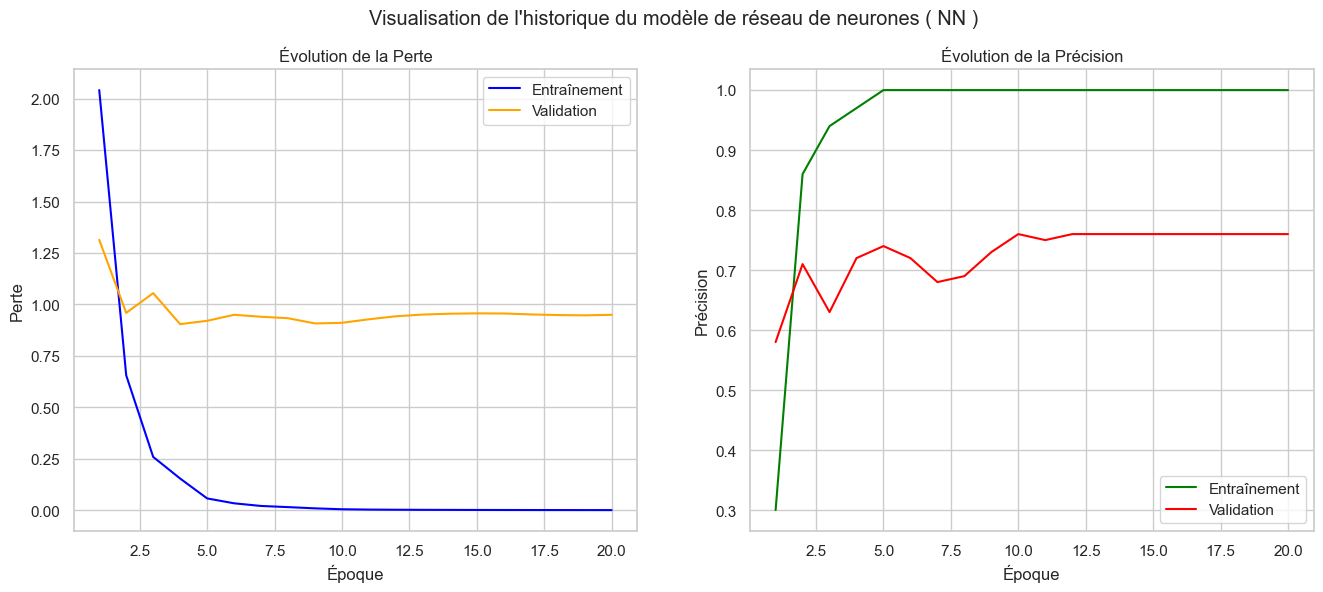

In [10]:
# Détermination du nombre d'époques
nb_epochs = len(historique_apprentissage.history['loss'])

# Configuration du style Seaborn
sns.set(style="whitegrid")

# Création de la figure avec une taille appropriée
plt.figure(figsize=(16, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_apprentissage.history['loss'], label='Entraînement', color='blue')
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_apprentissage.history['val_loss'], label='Validation', color='orange')
plt.title('Évolution de la Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Courbe de précision
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_apprentissage.history['accuracy'], label='Entraînement', color='green')
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_apprentissage.history['val_accuracy'], label='Validation', color='red')
plt.title('Évolution de la Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Ajout du titre à la figure
plt.suptitle("Visualisation de l'historique du modèle de réseau de neurones ( NN )")
plt.show()

#### `Évaluation` et `Visualisation` des Métriques de Classification

313/313 [==============================] - 2s 6ms/step


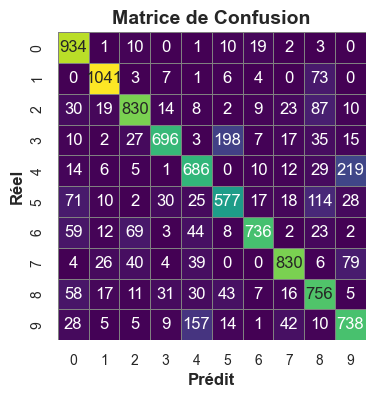

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.77      0.95      0.85       980
           1       0.91      0.92      0.92      1135
           2       0.83      0.80      0.82      1032
           3       0.88      0.69      0.77      1010
           4       0.69      0.70      0.69       982
           5       0.67      0.65      0.66       892
           6       0.91      0.77      0.83       958
           7       0.86      0.81      0.83      1028
           8       0.67      0.78      0.72       974
           9       0.67      0.73      0.70      1009

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000


Résultats de l'Évaluation sur l'Ensemble de Test :
>> Précision : 0.7824


In [11]:
# Prédiction sur l'ensemble de test
y_pred = np.argmax(modele_reseau_neurones.predict(x_test), axis=1)

# Calcul de la matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)

# Tracer la matrice de confusion avec un style amélioré
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_confusion, annot=True, fmt="d", cmap="viridis", cbar=False, square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10), linewidths=.5, linecolor='gray')
plt.xlabel('Prédit', fontsize=12, fontweight='bold')
plt.ylabel('Réel', fontsize=12, fontweight='bold')
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Rapport de classification
rapport_classification = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Rapport de Classification:\n", rapport_classification)

# Affichage des résultats d'évaluation
precision = accuracy_score(y_test, y_pred)

print("\nRésultats de l'Évaluation sur l'Ensemble de Test :")
print(f">> Précision : {precision}")

## <p style="color:red;"><span style="color:black;">Modèle 2️⃣ : Modèle de Réseau de Neurones avec drop `Drop_NN` sur 100 Échantillons</span></p>
> - Dans un deuxiéme  temps, comme mentionné dans l'article, nous allons utiliser le modèle proposé, le modèle drop NN, qui est un modèle evalué de NN avec des couche de dropout. nous allons utilser ce modele qui a le drop out pour voir comment ces perfomances evoluent

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
<b><code>Le concept de dropout dans le deep learning</code></b> est une technique de régularisation utilisée pour prévenir le surajustement dans les réseaux neuronaux. Il consiste à aléatoirement "supprimer" (ignorer) un certain pourcentage de neurones pendant l'entraînement, ce qui permet d'améliorer la généralisation du modèle. Cette approche contribue souvent à obtenir des modèles plus robustes et performants.

[Plus d'informations..](https://inside-machinelearning.com/le-dropout-cest-quoi-deep-learning-explication-rapide/)
</div>

#### Création du modèle de Réseau de Neurones avec `Couches Dropout`

In [12]:
# Création du modèle DropNN : réseau de neurones avec un Dropout de 0.5 pour les couches cachées et 0.2 pour la couche d'entrée
modele_dropNN = Sequential()
# Ajout d'une couche Dropout pour les entrées avec un taux de 0.2
modele_dropNN.add(Dropout(0.2, input_shape=(784,)))
# Ajout d'une couche dense avec 5000 neurones et une fonction d'activation ReLU
modele_dropNN.add(Dense(5000, activation='relu'))
# Ajout d'une couche Dropout avec un taux de 0.5
modele_dropNN.add(Dropout(0.5))
# Ajout d'une couche dense avec 10 neurones et une fonction d'activation sigmoïde
modele_dropNN.add(Dense(10, activation='sigmoid'))

# Affichage du résumé du modèle
modele_dropNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 5000)              3925000   
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                50010     
                                                                 
Total params: 3975010 (15.16 MB)
Trainable params: 3975010 (15.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Configuration de l'`Optimiseur` avec `Taux d'Apprentissage Exponentiel`

In [13]:
# Définition d'une planification de taux d'apprentissage exponentielle
planification_lr_exponentielle = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.5,
    decay_steps=10,
    decay_rate=0.88
)

# Création d'un optimiseur SGD avec la planification de taux d'apprentissage exponentielle
optimiseur = keras.optimizers.SGD(learning_rate=planification_lr_exponentielle)

#### Configuration du Modèle DropNN

In [14]:
modele_dropNN.compile(optimizer=optimiseur, 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

# Affichage de la configuration du modèle
print("Configuration du Modèle :")
print(f"   Optimiseur : SGD Optimizer")
print(f"   Fonction de Perte : 'sparse_categorical_crossentropy'")
print(f"   Métriques : ['accuracy']")

Configuration du Modèle :
   Optimiseur : SGD Optimizer
   Fonction de Perte : 'sparse_categorical_crossentropy'
   Métriques : ['accuracy']


#### Apprentissage du `Modèle DropNN` avec les 100 Données Étiquetées

In [15]:
# Entraînement du modèle DropNN avec les données étiquetées (100 époques, batch size de 16) et validation
historique_dropNN = modele_dropNN.fit(
    x_etiquetees, 
    y_etiquetees,
    epochs=100, 
    batch_size=16,
    validation_data=(x_validation, y_validation)
)

# Affichage de l'historique d'apprentissage
print("\nHistorique d'Apprentissage :")
print(f" >> Nombre d'époques : {len(historique_dropNN.history['loss'])}")
print(f" >> Perte moyenne finale : {historique_dropNN.history['loss'][-1]:.4f}")
print(f" >> Précision moyenne finale : {historique_dropNN.history['accuracy'][-1]:.4f}")
print(f" >> Validation Perte moyenne finale : {historique_dropNN.history['val_loss'][-1]:.4f}")
print(f" >> Validation Précision moyenne finale : {historique_dropNN.history['val_accuracy'][-1]:.4f}")

Epoch 1/100
7/7 [==============================] - 1s 52ms/step - loss: 81.4814 - accuracy: 0.1000 - val_loss: 64.3078 - val_accuracy: 0.1100
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 4132.9717 - accuracy: 0.1300 - val_loss: 635.1395 - val_accuracy: 0.1100
Epoch 3/100
7/7 [==============================] - 0s 28ms/step - loss: 363.3368 - accuracy: 0.1400 - val_loss: 99.5256 - val_accuracy: 0.1100
Epoch 4/100
7/7 [==============================] - 0s 28ms/step - loss: 98.6816 - accuracy: 0.1900 - val_loss: 22.2817 - val_accuracy: 0.1800
Epoch 5/100
7/7 [==============================] - 0s 31ms/step - loss: 11.4246 - accuracy: 0.3300 - val_loss: 9.9729 - val_accuracy: 0.2100
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 9.5525 - accuracy: 0.2600 - val_loss: 6.6100 - val_accuracy: 0.2100
Epoch 7/100
7/7 [==============================] - 0s 31ms/step - loss: 6.4163 - accuracy: 0.2800 - val_loss: 7.6978 - val_accuracy: 0.2400
Epoch 8

#### Visualisation de l'historique du modèle de réseau de neurones avec `Couches Dropout`

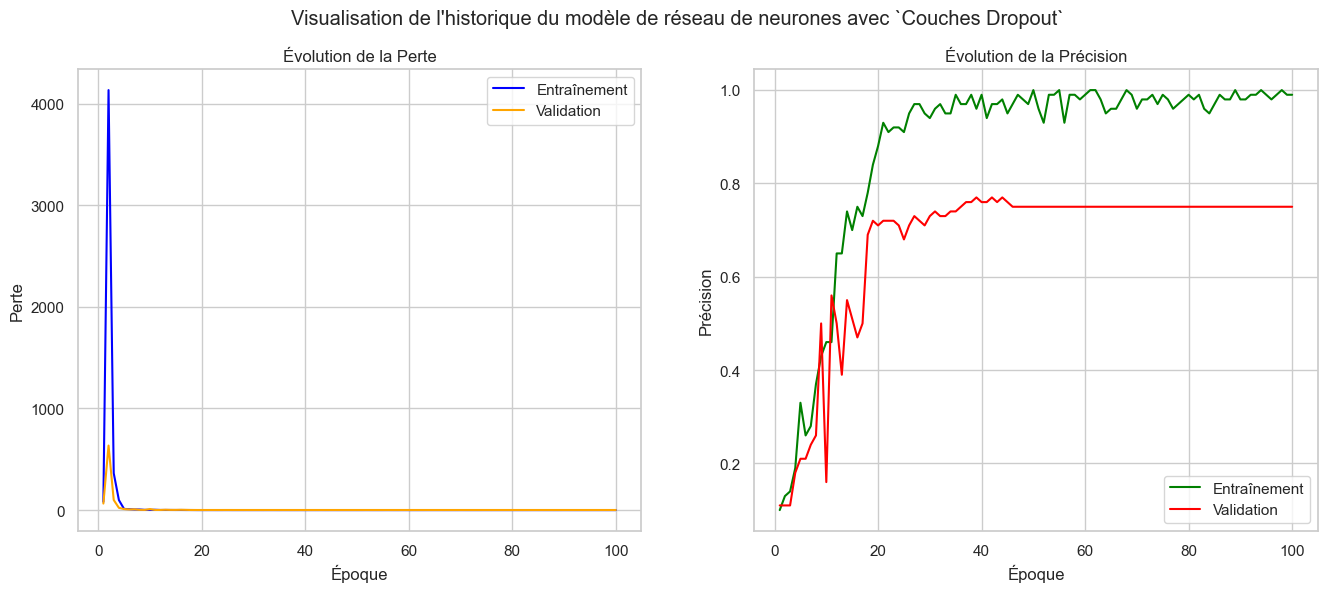

In [16]:
# Détermination du nombre d'époques
nb_epochs = len(historique_dropNN.history['loss'])

# Configuration du style Seaborn
sns.set(style="whitegrid")

# Création de la figure avec une taille appropriée
plt.figure(figsize=(16, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_dropNN.history['loss'], label='Entraînement', color='blue')
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_dropNN.history['val_loss'], label='Validation', color='orange')
plt.title('Évolution de la Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Courbe de précision
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_dropNN.history['accuracy'], label='Entraînement', color='green')
sns.lineplot(x=range(1, nb_epochs + 1), y=historique_dropNN.history['val_accuracy'], label='Validation', color='red')
plt.title('Évolution de la Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Ajout du titre à la figure
plt.suptitle("Visualisation de l'historique du modèle de réseau de neurones avec `Couches Dropout`")
plt.show()

#### `Évaluation` et `Visualisation` des Métriques de Classification

313/313 [==============================] - 2s 6ms/step


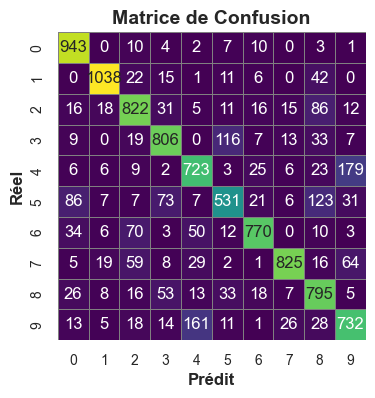

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       980
           1       0.94      0.91      0.93      1135
           2       0.78      0.80      0.79      1032
           3       0.80      0.80      0.80      1010
           4       0.73      0.74      0.73       982
           5       0.72      0.60      0.65       892
           6       0.88      0.80      0.84       958
           7       0.92      0.80      0.86      1028
           8       0.69      0.82      0.75       974
           9       0.71      0.73      0.72      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.80     10000


Résultats de l'Évaluation sur l'Ensemble de Test :
>> Précision : 0.7985


In [17]:
# Prédiction sur l'ensemble de test
y_pred = np.argmax(modele_dropNN.predict(x_test), axis=1)

# Calcul de la matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)

# Tracer la matrice de confusion avec un style amélioré
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_confusion, annot=True, fmt="d", cmap="viridis", cbar=False, square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10), linewidths=.5, linecolor='gray')
plt.xlabel('Prédit', fontsize=12, fontweight='bold')
plt.ylabel('Réel', fontsize=12, fontweight='bold')
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Rapport de classification
rapport_classification = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Rapport de Classification:\n", rapport_classification)

# Affichage des résultats d'évaluation
precision = accuracy_score(y_test, y_pred)

print("\nRésultats de l'Évaluation sur l'Ensemble de Test :")
print(f">> Précision : {precision}")

## <p style="color:red;"><span style="color:black;">Modèle 3️⃣ : `DropNN` avec `PseudoLabeling` (Semi-Supervisé)</span></p>

> - Comme discuté dans l'article, nous allons maintenant définir et implémenter le pseudo labeling dans le modèle DropNN.

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
<b><code>Le Pseudo Labling dans l'apprentissage semi-supervisé</code></b> est une technique où, en plus des exemples d'entraînement étiquetés, des exemples non étiquetés sont également utilisés pour l'entraînement. Les prédictions du modèle sur les données non étiquetées sont ensuite traitées comme des "pseudos-étiquettes" et sont intégrées dans le processus d'entraînement. Cette approche vise à améliorer les performances du modèle en utilisant un ensemble de données plus large et diversifié.

[Plus d'informations sur le Pseudo dans le cadre de l'apprentissage semi-supervisé](https://arxiv.org/abs/2211.10039)
</div>

#### Prédiction avec Pseudo-Étiquetage

In [18]:
# Prédiction des étiquettes pseudo avec le modèle DropNN sur les données non étiquetées
predictions_pseudo_etiquettes = modele_dropNN.predict(x_non_etiquetees)

# Initialisation de la liste des étiquettes pseudo
y_pseudo_etiquettes = []

# Extraction des étiquettes pseudo en prenant l'indice du maximum de chaque prédiction
for i in range(len(predictions_pseudo_etiquettes)):
    y_pseudo_etiquettes.append(np.argmax(predictions_pseudo_etiquettes[i]))

1869/1869 [==============================] - 12s 6ms/step


#### Configuration de l'Optimiseur et de la Fonction de Perte pour le Pseudo-Étiquetage

In [19]:
# Configuration de l'optimiseur Adam pour le pseudo-étiquetage
optimiseur_pseudo_etiquetage = keras.optimizers.Adam()

# Configuration de la fonction de perte catégorielle sparse pour le pseudo-étiquetage
fonction_perte_pseudo_etiquetage = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#### Préparation des Datasets d'Apprentissage : `Images Labelisées` et `Pseudo-Étiquetées`

In [20]:
# Tailles de lot (batch size) pour les données étiquetées et pseudo-étiquetées
taille_lot_etiquete = 32
taille_lot_PseudoEtiquette = 256

# Création des datasets d'apprentissage avec les images étiquetées et pseudo-étiquetées
ensemble_apprentissage_etiquete = tf.data.Dataset.from_tensor_slices((x_etiquetees, y_etiquetees))
ensemble_apprentissage_etiquete = ensemble_apprentissage_etiquete.shuffle(buffer_size=1024).batch(taille_lot_etiquete)

ensemble_apprentissage_PseudoEtiquette = tf.data.Dataset.from_tensor_slices((x_non_etiquetees, y_pseudo_etiquettes))
ensemble_apprentissage_PseudoEtiquette = ensemble_apprentissage_PseudoEtiquette.shuffle(buffer_size=1024).batch(taille_lot_PseudoEtiquette)

# Dataset de validation
ensemble_validation = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
ensemble_validation = ensemble_validation.batch(taille_lot_etiquete)  # Utilisation de la même taille de lot que pour les données étiquetées

#### Entraînement avec `Pseudo-Étiquetage` et `Validation`

> <b> Fonction d'entraînement avec pseudo-étiquetage </b>

La fonction `etape_apprentissage` est conçue pour l'entraînement d'un modèle de réseau de neurones dans un scénario semi-supervisé avec pseudo-étiquetage. Voici un résumé de son fonctionnement :

> <b> Stratégie de Pseudo-Étiquetage </b>
- L'hyperparamètre `alpha` est ajusté linéairement entre les époques `T1` et `T2`.
- La fonction de perte combine la perte sur les données étiquetées et la perte pondérée sur les données pseudo-étiquetées.

> <b> Entraînement </b>
1. Calcul des logits pour les données étiquetées et pseudo-étiquetées.
2. Ajustement de l'hyperparamètre `alpha` en fonction de l'époque.
3. Calcul de la perte totale en combinant les deux types de données.
4. Calcul des gradients de la perte par rapport aux poids du modèle.
5. Application des gradients à l'optimiseur pour mettre à jour les poids du modèle.tées sont limitées.


In [21]:
# Fonction d'entraînement avec pseudo-étiquetage
def etape_apprentissage(x_etiquete, y_etiquete, x_PseudoEtiquette, y_PseudoEtiquette, epoque):
    """
    Fonction d'entraînement avec pseudo-étiquetage.

    Parameters:
        x_etiquete (tf.Tensor): Données d'entraînement étiquetées.
        y_etiquete (tf.Tensor): Étiquettes correspondant aux données étiquetées.
        x_PseudoEtiquette (tf.Tensor): Données d'entraînement pseudo-étiquetées.
        y_PseudoEtiquette (tf.Tensor): Pseudo-étiquettes correspondant aux données pseudo-étiquetées.
        epoque (int): Numéro de l'époque actuelle.

    Returns:
        tf.Tensor: Valeur de perte pour l'époque actuelle.
    """
    alpha = 0.
    T1 = 100
    T2 = 600
    af = 3.

    with tf.GradientTape() as tape:
        logits_etiquete = modele_dropNN(x_etiquete, training=True)
        logits_PseudoEtiquette = modele_dropNN(x_PseudoEtiquette, training=True)

        if epoque > T1:
            alpha = ((epoque - T1) / (T2 - T1)) * af
            if epoque > T2:
                alpha = af
        
        # Calcul de la valeur de perte
        valeur_perte = fonction_perte_pseudo_etiquetage(y_etiquete, logits_etiquete) + alpha * fonction_perte_pseudo_etiquetage(y_PseudoEtiquette, logits_PseudoEtiquette)
        # Application des gradients à l'optimiseur
        gradients = tape.gradient(valeur_perte, modele_dropNN.trainable_weights)

    optimiseur_pseudo_etiquetage.apply_gradients(zip(gradients, modele_dropNN.trainable_weights))
    return valeur_perte

##### Boucle d'Apprentissage

- **Époques :** Nous itérons sur un nombre prédéfini d'époques.
- **Métriques d'Entraînement :** Nous stockons la perte moyenne et la précision pour chaque époque pendant l'entraînement.
- **Métriques de Validation :** Nous calculons également ces métriques sur un ensemble de validation distinct.
- **Affichage des Résultats :** Les résultats, y compris la perte, la précision, la perte de validation et la précision de validation, sont affichés à chaque époque.

In [22]:
# Boucle d'apprentissage avec validation
epochs = 100

# Listes pour stocker la perte et la précision d'entraînement pour chaque époque
pertes_entrainement = []
precisions_entrainement = []

# Listes pour la validation
pertes_validation = []
precisions_validation = []

for epoque in range(epochs):
    print("\nDébut de l'époque %d" % (epoque,))
    temps_depart = time.time()
    etape = 1

    perte_epoque = 0.0
    predictions_correctes = 0
    total_echantillons = 0

    # Boucle d'entraînement
    for (lot_x_etiquete, lot_y_etiquete), (lot_x_pseudo_etiquete, lot_y_pseudo_etiquete) in zip(ensemble_apprentissage_etiquete, ensemble_apprentissage_PseudoEtiquette):
        # Appel de la fonction d'entraînement
        valeur_perte = etape_apprentissage(lot_x_etiquete, lot_y_etiquete, lot_x_pseudo_etiquete, lot_y_pseudo_etiquete, epoque)

        # Mise à jour des métriques
        perte_epoque += valeur_perte.numpy()

        logits_etiquete = modele_dropNN(lot_x_etiquete, training=False)
        predictions_etiquete = np.argmax(logits_etiquete, axis=1)
        predictions_correctes += np.sum(predictions_etiquete == lot_y_etiquete.numpy())
        total_echantillons += len(lot_y_etiquete)

    # Calcul des métriques d'entraînement
    perte_moyenne = perte_epoque / etape
    precision = predictions_correctes / total_echantillons

    # Stockage des métriques d'entraînement
    pertes_entrainement.append(perte_moyenne)
    precisions_entrainement.append(precision)

    # Boucle de validation
    perte_validation = 0.0
    predictions_correctes_validation = 0
    total_echantillons_validation = 0

    for lot_x_validation, lot_y_validation in ensemble_validation:
        logits_validation = modele_dropNN(lot_x_validation, training=False)
        perte_validation += fonction_perte_pseudo_etiquetage(lot_y_validation, logits_validation).numpy()

        predictions_validation = np.argmax(logits_validation, axis=1)
        predictions_correctes_validation += np.sum(predictions_validation == lot_y_validation.numpy())
        total_echantillons_validation += len(lot_y_validation)

    # Calcul des métriques de validation
    perte_moyenne_validation = perte_validation / total_echantillons_validation
    precision_validation = predictions_correctes_validation / total_echantillons_validation

    # Stockage des métriques de validation
    pertes_validation.append(perte_moyenne_validation)
    precisions_validation.append(precision_validation)

    # Affichage des résultats de l'époque
    print("Époque %d : Temps écoulé : %.2fs, Perte : %.4f, Précision : %.4f, Perte Validation : %.4f, Précision Validation : %.4f" % (
        epoque, time.time() - temps_depart, perte_moyenne, precision, perte_moyenne_validation, precision_validation))


Début de l'époque 0
Époque 0 : Temps écoulé : 1.06s, Perte : 0.4457, Précision : 1.0000, Perte Validation : 0.0338, Précision Validation : 0.7500

Début de l'époque 1
Époque 1 : Temps écoulé : 0.84s, Perte : 0.3123, Précision : 1.0000, Perte Validation : 0.0344, Précision Validation : 0.7400

Début de l'époque 2
Époque 2 : Temps écoulé : 0.91s, Perte : 0.4017, Précision : 1.0000, Perte Validation : 0.0345, Précision Validation : 0.7400

Début de l'époque 3
Époque 3 : Temps écoulé : 0.92s, Perte : 0.2715, Précision : 1.0000, Perte Validation : 0.0350, Précision Validation : 0.7500

Début de l'époque 4
Époque 4 : Temps écoulé : 0.88s, Perte : 0.1383, Précision : 1.0000, Perte Validation : 0.0361, Précision Validation : 0.7500

Début de l'époque 5
Époque 5 : Temps écoulé : 0.89s, Perte : 0.1392, Précision : 1.0000, Perte Validation : 0.0371, Précision Validation : 0.7600

Début de l'époque 6
Époque 6 : Temps écoulé : 0.90s, Perte : 0.1753, Précision : 1.0000, Perte Validation : 0.0370, P

#### Visualisation de l'historique du modèle `DropNN` avec `PseudoLabeling`

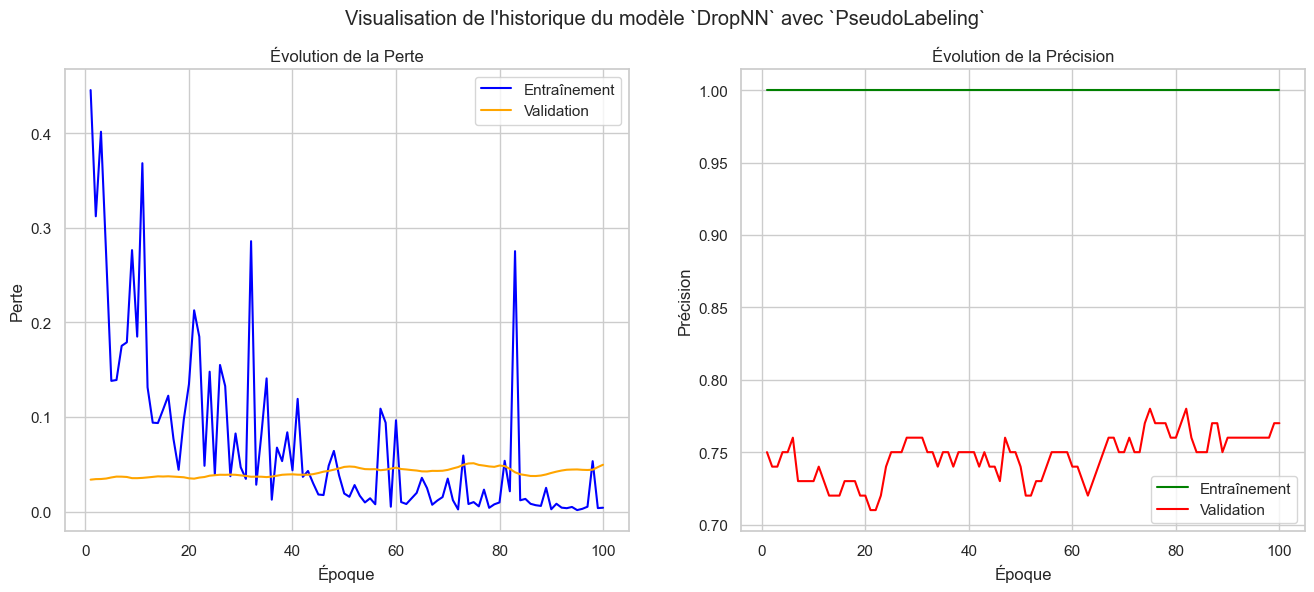

In [23]:
# Création de la figure
plt.figure(figsize=(16, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, epochs + 1), y=pertes_entrainement, label='Entraînement', color='blue')
sns.lineplot(x=range(1, epochs + 1), y=pertes_validation, label='Validation', color='orange')
plt.title('Évolution de la Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Courbe de précision
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, epochs + 1), y=precisions_entrainement, label='Entraînement', color='green')
sns.lineplot(x=range(1, epochs + 1), y=precisions_validation, label='Validation', color='red')
plt.title('Évolution de la Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Ajout du titre à la figure
plt.suptitle("Visualisation de l'historique du modèle `DropNN` avec `PseudoLabeling`")

# Affichage de la figure
plt.show()

#### `Évaluation` et `Visualisation` des Métriques de Classification

313/313 [==============================] - 2s 6ms/step


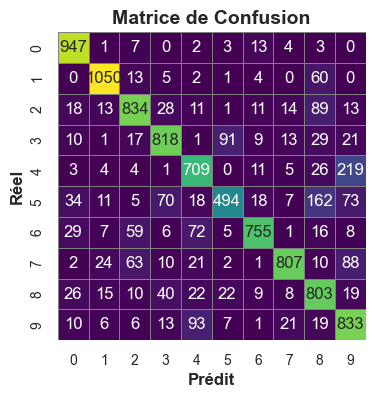

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       980
           1       0.93      0.93      0.93      1135
           2       0.82      0.81      0.81      1032
           3       0.83      0.81      0.82      1010
           4       0.75      0.72      0.73       982
           5       0.79      0.55      0.65       892
           6       0.91      0.79      0.84       958
           7       0.92      0.79      0.85      1028
           8       0.66      0.82      0.73       974
           9       0.65      0.83      0.73      1009

    accuracy                           0.81     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.81      0.80     10000


Résultats de l'Évaluation sur l'Ensemble de Test :
>> Précision : 0.805


In [24]:
# Prédiction sur l'ensemble de test
y_pred = np.argmax(modele_dropNN.predict(x_test), axis=1)

# Calcul de la matrice de confusion
matrice_confusion = confusion_matrix(y_test, y_pred)

# Tracer la matrice de confusion avec un style amélioré
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_confusion, annot=True, fmt="d", cmap="viridis", cbar=False, square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10), linewidths=.5, linecolor='gray')
plt.xlabel('Prédit', fontsize=12, fontweight='bold')
plt.ylabel('Réel', fontsize=12, fontweight='bold')
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Rapport de classification
rapport_classification = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Rapport de Classification:\n", rapport_classification)

# Affichage des résultats d'évaluation
precision = accuracy_score(y_test, y_pred)

print("\nRésultats de l'Évaluation sur l'Ensemble de Test :")
print(f">> Précision : {precision}")